# Using data from AWS with intake_esm

Data from CESM Large Ensemble, CMIP5, CMIP6 and more are publicly available. For a single file, we can specify the file location and use fsspec and xarray.open_zarr to create a dataset. For several files, we can use the intake_esm module to obtain the data, put it into an xarray.Dataset and then plot or gather metrics using ldcpy. This notebook shows how to use an ESM collection to gather this data, put it into a dataset and create a simple plot using the data.

In [88]:
# Add ldcpy root to system path
import sys
sys.path.insert(0,'../../../')

# Import ldcpy package
# Autoreloads package everytime the package is called, so changes to code will be reflected in the notebook if the above sys.path.insert(...) line is uncommented.
%load_ext autoreload
%autoreload 2
import ldcpy
import intake
import fsspec
import xarray as xr

#display the plots in this notebook
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Method 1: using fsspec and xr.open_zarr

First, specify the filesystem and location of the data, here we are storing the data on Amazon S3 in the _"ncar-cesm-lens-baker-lossy-compression-test"_ bucket, and listing all available files (each containing a single variable for that dataset.

In [90]:
fs = fsspec.filesystem('s3', anon=True)
stores = fs.ls("ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/")[1:]
stores[:]

['ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FLNS.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FLNSC.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FLUT.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FSNS.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FSNSC.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-FSNTOA.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-ICEFRAC.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-LHFLX.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-PRECL.zarr',
 'ncar-cesm-lens-baker-lossy-compression-test/lens-ens31/cesmle-atm-ens31-20C-daily-PRECSC.zarr',
 'ncar-cesm-lens-baker-lossy-

Then we select the file we want and open it as an xarray.Dataset using xr.open_zarr(), here we grab data for the FLNS variable: 

In [77]:
store = fs.get_mapper(stores[0])
ds = xr.open_zarr(store, consolidated=True, decode_times=False)
ds

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 31391)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) float64 0.0 1.0 2.0 3.0 ... 3.139e+04 3.139e+04 3.139e+04
Dimensions without coordinates: nbnd
Data variables:
    FLNS       (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
    time_bnds  (time, nbnd) float64 dask.array<chunksize=(15696, 2), meta=np.ndarray>
Attributes:
    Conventions:      CF-1.0
    Version:          $Name$
    case:             b.e11.B20TRC5CNBDRD.f09_g16.031
    host:             ys0219
    initial_file:     b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-01-00000.nc
    logname:          mickelso
    revision_Id:      $Id$
    source:           CAM
    title:            UNSET
    topography_file:  /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/USGS-gtop...

Finally, we plot the variable:

FLNS - 	Net longwave flux at surface

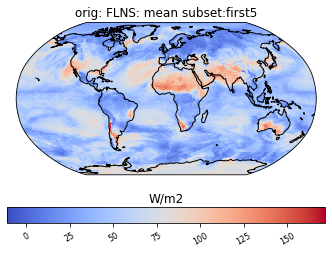

In [92]:
ldcpy.plot(ds, "FLNS", set1='orig', metric='mean', subset='first5')

## Method 2: Using intake_esm

If we want data from several files, we can use the intake_esm module to search for, and open several files as xarray.Dataset objects. Then we can then plot or gather metrics using ldcpy as before.

Below is an example that uses data from CESM Large Ensemble, member 31. This is a compressed dataset that was used in a Blind Evaluation of Lossy Data-Compression in LENS (http://www.cesm.ucar.edu/projects/community-projects/LENS/projects/lossy-data-compression.html). More catalogs for publicly available datasets can be found at https://github.com/NCAR/intake-esm-datastore/tree/master/catalogs.

The code below is taken and modified from the intake_esm documentation, available here: https://intake-esm.readthedocs.io/en/latest/?badge=latest#overview.

First, we open the collection (for information on collection specification, see here: https://github.com/NCAR/esm-collection-spec/blob/master/collection-spec/collection-spec.md#attribute-object.

In [78]:
col = intake.open_esm_datastore("./collections/test_collection.json")
col

,unique
component,1
frequency,1
experiment,1
variable,3
path,3


Next, we search for the dataset and variables we are interested in (https://intake-esm.readthedocs.io/en/latest/api.html#intake_esm.core.esm_datastore.search):

In [80]:
col_subset = col.search(component='atm', frequency='daily', experiment='20C',variable=["ICEFRAC", "PRECT", "FLUT"])
col_subset.df.head()

,component,frequency,experiment,variable,path
0,atm,daily,20C,ICEFRAC,s3://ncar-cesm-lens-baker-lossy-compression-te...
1,atm,daily,20C,PRECT,s3://ncar-cesm-lens-baker-lossy-compression-te...
2,atm,daily,20C,FLUT,s3://ncar-cesm-lens-baker-lossy-compression-te...


Then we load matching catalog entries into xarray datasets (https://intake-esm.readthedocs.io/en/latest/api.html#intake_esm.core.esm_datastore.to_dataset_dict):

In [81]:
dsets = col_subset.to_dataset_dict(zarr_kwargs={"consolidated": True, 'decode_times': False}, storage_options={"anon": True})
dsets


--> The keys in the returned dictionary of datasets are constructed as follows:
	'component.experiment.frequency'


{'atm.20C.daily': <xarray.Dataset>
 Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 31391)
 Coordinates:
   * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
   * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
   * time       (time) float64 0.0 1.0 2.0 3.0 ... 3.139e+04 3.139e+04 3.139e+04
 Dimensions without coordinates: nbnd
 Data variables:
     ICEFRAC    (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
     time_bnds  (time, nbnd) float64 dask.array<chunksize=(15696, 2), meta=np.ndarray>
     PRECT      (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
     FLUT       (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
 Attributes:
     topography_file:         /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/US...
     initial_file:            b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-01...
     intake_esm_varname:      FLUT
     lognam

Check the dataset keys to ensure that the dataset we want is present:

In [82]:
dsets.keys()

dict_keys(['atm.20C.daily'])

Finally, put the values we are interested from the dictionary into their own dataset variable:

In [83]:
aws_ds=(dsets['atm.20C.daily'])
aws_ds

<xarray.Dataset>
Dimensions:    (lat: 192, lon: 288, nbnd: 2, time: 31391)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time       (time) float64 0.0 1.0 2.0 3.0 ... 3.139e+04 3.139e+04 3.139e+04
Dimensions without coordinates: nbnd
Data variables:
    ICEFRAC    (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
    time_bnds  (time, nbnd) float64 dask.array<chunksize=(15696, 2), meta=np.ndarray>
    PRECT      (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
    FLUT       (time, lat, lon) float32 dask.array<chunksize=(576, 192, 288), meta=np.ndarray>
Attributes:
    topography_file:         /glade/p/cesmdata/cseg/inputdata/atm/cam/topo/US...
    initial_file:            b.e11.B20TRC5CNBDRD.f09_g16.001.cam.i.1920-01-01...
    intake_esm_varname:      FLUT
    logname:                 mickelso
    source:                  CAM
    Conventions:             CF-1.0
    revision_Id:             $Id$
    title:                   UNSET
    Version:                 $Name$
    case:                    b.e11.B20TRC5CNBDRD.f09_g16.031
    host:                    ys0219
    intake_esm_dataset_key:  atm.20C.daily

As we can see above, the dataset has the required lat, lon, and time dimensions and coordinates, and a ICEFRAC, PRECT and FLUT variables. We can use ldcpy's plotting function to plot metrics from this dataset. Below, we plot the mean value of FLUT for the first five time slices at each lat and lon coordinate in the dataset (the full dataset may take a  long time to run on a personal computer):

ICEFRAC - Fraction of sfc area covered by sea-ice (note this will be 0 over land)

PRECT - Total (convective and large-scale) precipitation rate (liq + ice)

FLUT - 	Upwelling longwave flux at top of model

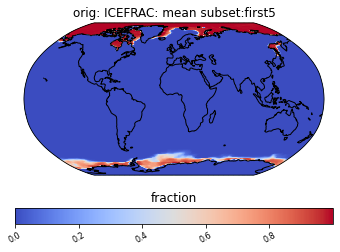

In [85]:
ldcpy.plot(aws_ds, "ICEFRAC", set1='orig', metric='mean', subset='first5')

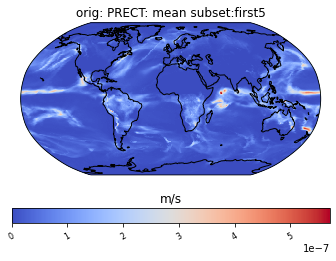

In [86]:
ldcpy.plot(aws_ds, "PRECT", set1='orig', metric='mean', subset='first5')

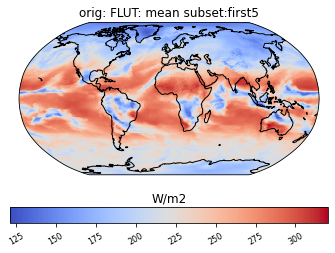

In [87]:
ldcpy.plot(aws_ds, "FLUT", set1='orig', metric='mean', subset='first5')